# Homework #1

Задача:
- Реализовать слои Sigmoid, Dense, Softmax, LogLoss с использование тензоров pytorch
- Реализовать двухслойную нейронную сеть для распознования цифр MNIST
- Обучить сеть. Обученная модель должна побить baseline на kaggle.

Отчет в этом ноутбуке должен содержать весь необходимый код воспроизведения полученных результатов.

In [1]:
import torch
from   torch import FloatTensor
import time
import random

In [2]:
class Sigmoid:
    def forward(self, x):
        self.x = x
        return 1 / ( 1 + ( -1 * x ).exp() )
        
    def backward(self, dz, lr):
        sr = self.forward(self.x)
        return dz * sr * ( 1 - sr )
    
    def cpu(self):
        self.W.cpu()
    
    def cuda(self):
        self.W.cuda()
    

In [3]:
class Dense:  
    def __init__(self, in_size, out_size):
        self.W   = torch.randn(out_size, in_size)
        self.Tet = torch.randn(out_size, 1)
    
    def forward(self, x):
        self.x = x
        return self.W.mm(x) + self.Tet
    
    def backward(self, dz, lr):
        dTet     = lr * dz
        dW       = lr * self.x.mm(dz.t()).t()
        
        dz       = ( dz.t().mm(self.W) ).t()
        
        self.W   = self.W    - dW
        self.Tet = self.Tet  - dTet
        
        return dz
    
    def cpu(self):
        self.W.cpu()
        self.Tet.cpu()

    def cuda(self):
        self.W.cuda()
        self.Tet.cuda()
        

In [4]:
class Softmax:
    def forward(self, x):
        self.x = x
        exps   = x.exp()
        return exps / exps.sum()
    
    def backward(self, dz, lr):
        sm  = self.forward(self.x)
        return torch.matmul(sm * torch.t(torch.eye(self.x.shape[0]) - sm), dz)

In [5]:
class LogLoss:
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat  = y_hat
        return -1 * sum( y_true * y_hat.log() )
    
    def backward(self, dz, lr=0.3):
        return -1 * dz * self.y_true / self.y_hat 
    
    def cpu(self):
        self.y_true.cpu()
        self.y_hat.cpu()

    def cuda(self):
        self.y_true.cuda()
        self.y_hat.cuda()

In [6]:
class Net:
    def __init__(self):
        self.D1 = Dense(784, 24)
        self.Si = Sigmoid()
        self.D2 = Dense(24, 10)
        self.SM = Softmax()
        
    def forward(self, x):
        Data  = self.D1.forward(x)
        Data  = self.Si.forward(Data)
        Data  = self.D2.forward(Data)
        res   = self.SM.forward(Data)
        return res
    
    def backward(self, dz, lr):
        dz = self.SM.backward(dz, lr)
        dz = self.D2.backward(dz, lr)
        dz = self.Si.backward(dz, lr)
        dz = self.D1.backward(dz, lr)
        return dz
    
    def cpu(self):
        self.D1.cpu()
        self.Si.cpu()
        self.D2.cpu()
        return self
        
    def cuda(self):
        self.D1.cuda()
        self.Si.cuda()
        self.D2.cuda()
        return self

# Загружаем датасет

In [7]:
import pickle

with open("./mnist_train.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("./mnist_test.pkl", "rb") as f:
    test_data = pickle.load(f)

# Разбор и нормировка входных данных

In [8]:
import numpy

# train dataset
X_   = train_data['data']
mean = numpy.mean(X_, axis=1, keepdims=True)
std  = numpy.std(X_, axis=1, keepdims=True)
X_   = (X_ - mean)/std
X    = [torch.FloatTensor(x).view(X_[0].shape[0], 1) for x in X_]

Y_   = train_data['target']
Y_t_ = numpy.zeros((Y_.shape[0], 10))
for i in range(Y_.shape[0]):
    Y_t_[i, int(Y_[i])] = 1
Y_t  = [torch.FloatTensor(y).view(10, 1) for y in Y_t_]

# test dataset
Xt_  = test_data['data']
mean = numpy.mean(Xt_, axis=1, keepdims=True)
std  = numpy.std(Xt_, axis=1, keepdims=True)
Xt_  = (Xt_ - mean)/std
Xt   = [torch.FloatTensor(x).view(X_[0].shape[0], 1) for x in Xt_]

# Обучаем сеть

In [19]:
net = Net()
LL  = LogLoss()

In [20]:
n_epoch = 25
lr = 0.001

L_Ep = [0]

since = time.time()

for i in range(n_epoch):
    L_sum = 0.0
    elr = lr * (0.5 ** (i//5))
    for j in range(len(X)):
        res = net.forward(X[j])
        
        Loss = LL.forward(Y_t[j], res)[0]
        L_sum += Loss
        
        dz   = LL.backward(1, elr)
        net.backward(dz, elr)
    
    L_sum = L_sum
    print( "Epoch {:3}, time {:3.1f}, Avg Loss {:.4f}, lr {:.6f}".format( i + 1, time.time() - since, L_sum / len(X), elr ) )
    L_Ep.append(L_sum)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s \n'.format(time_elapsed // 60, time_elapsed % 60))

Epoch   1, time 9.4, Avg Loss 1.8740, lr 0.001
Epoch   2, time 18.7, Avg Loss 1.0521, lr 0.001
Epoch   3, time 28.1, Avg Loss 0.8460, lr 0.001
Epoch   4, time 37.6, Avg Loss 0.7388, lr 0.001
Epoch   5, time 47.4, Avg Loss 0.6712, lr 0.001
Epoch   6, time 57.1, Avg Loss 0.6313, lr 0.0005
Epoch   7, time 66.7, Avg Loss 0.6111, lr 0.0005
Epoch   8, time 76.3, Avg Loss 0.5935, lr 0.0005
Epoch   9, time 85.9, Avg Loss 0.5779, lr 0.0005
Epoch  10, time 95.5, Avg Loss 0.5640, lr 0.0005
Epoch  11, time 105.2, Avg Loss 0.5532, lr 0.00025
Epoch  12, time 115.0, Avg Loss 0.5472, lr 0.00025
Epoch  13, time 124.9, Avg Loss 0.5414, lr 0.00025
Epoch  14, time 134.8, Avg Loss 0.5359, lr 0.00025
Epoch  15, time 144.6, Avg Loss 0.5306, lr 0.00025
Epoch  16, time 155.6, Avg Loss 0.5261, lr 0.000125
Epoch  17, time 165.4, Avg Loss 0.5236, lr 0.000125
Epoch  18, time 175.6, Avg Loss 0.5211, lr 0.000125
Epoch  19, time 186.7, Avg Loss 0.5187, lr 0.000125
Epoch  20, time 197.0, Avg Loss 0.5163, lr 0.000125
E

# Проверка сети

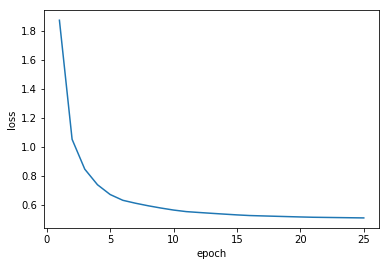

In [31]:
import matplotlib.pyplot as plt
plt.plot([x + 1 for x in range(n_epoch)], [x / len(X) for x in L_Ep[1:]])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [46]:
def predicted(x):
    maxi  = 0
    maxp  = 0
    for i in range(10):
        if x[i][0] > maxp:
            maxp, maxi = x[i][0], i
    return maxi

for i in range(10):
    numb = random.randint(0, len(X))
    netres = net.forward(X[numb])
    pred = predicted(netres)
    real = predicted(Y_t[numb])
    print( "Predicted {0}, Real {1}".format(pred, real) )
    
success = 0    
for i in range(len(X)):
    netres = net.forward(X[i])
    
    pred = predicted(netres)
    real = predicted(Y_t[i])
    
    if pred == real:
        success = success + 1

print( "Total accuracy {0} from {1} : {2}%".format( success, len(X), (100**2 * success/len(X)) //100) )

Predicted 1, Real 1
Predicted 5, Real 5
Predicted 3, Real 3
Predicted 1, Real 8
Predicted 8, Real 8
Predicted 0, Real 0
Predicted 6, Real 6
Predicted 9, Real 9
Predicted 5, Real 5
Predicted 9, Real 3
Total accuracy 50365 from 59500 : 84.0%


# Сохраняем результат для kaggle

https://www.kaggle.com/c/track-nn-2018-spring-1

In [34]:
with open("net_dump.pkl", "wb") as f:
    pickle.dump(net, f)

In [44]:
with open("kaggle_submition.csv", "wt") as f:
    f.write('id,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9\n')
    for i in range(len(Xt)):
        netres = net.forward(Xt[i])
        v = [netres[x][0] for x in range(10)]
        f.write(','.join([str(i)] + list(map(str, v))) + '\n')
                